In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### MRZ line detection using angle brackets
In this notebook I describe the steps I took to first extract the angle brackets that are part of the machine readable zone (MRZ) in identification documents. I will then extract the whole MRZ lines and use the segmented angle brackets for verification.

In this notebook, we address the issue of costly labeled training data by generating synthetic data. The features of the training data generated include:

- Images in grayscale, as it allows for faster processing and debugging.
- Utilization of random slices of Midv500 pictures as backgrounds, with only pictures that do not contain MRZ being used.
- A random pattern of angle brackets, characters, and whitespace.
- Light scaling and perspective shift, with the potential for further increase.
- A chance of corruption by various types of noise, including Gaussian blur, Salt & Pepper noise, and Gaussian noise.

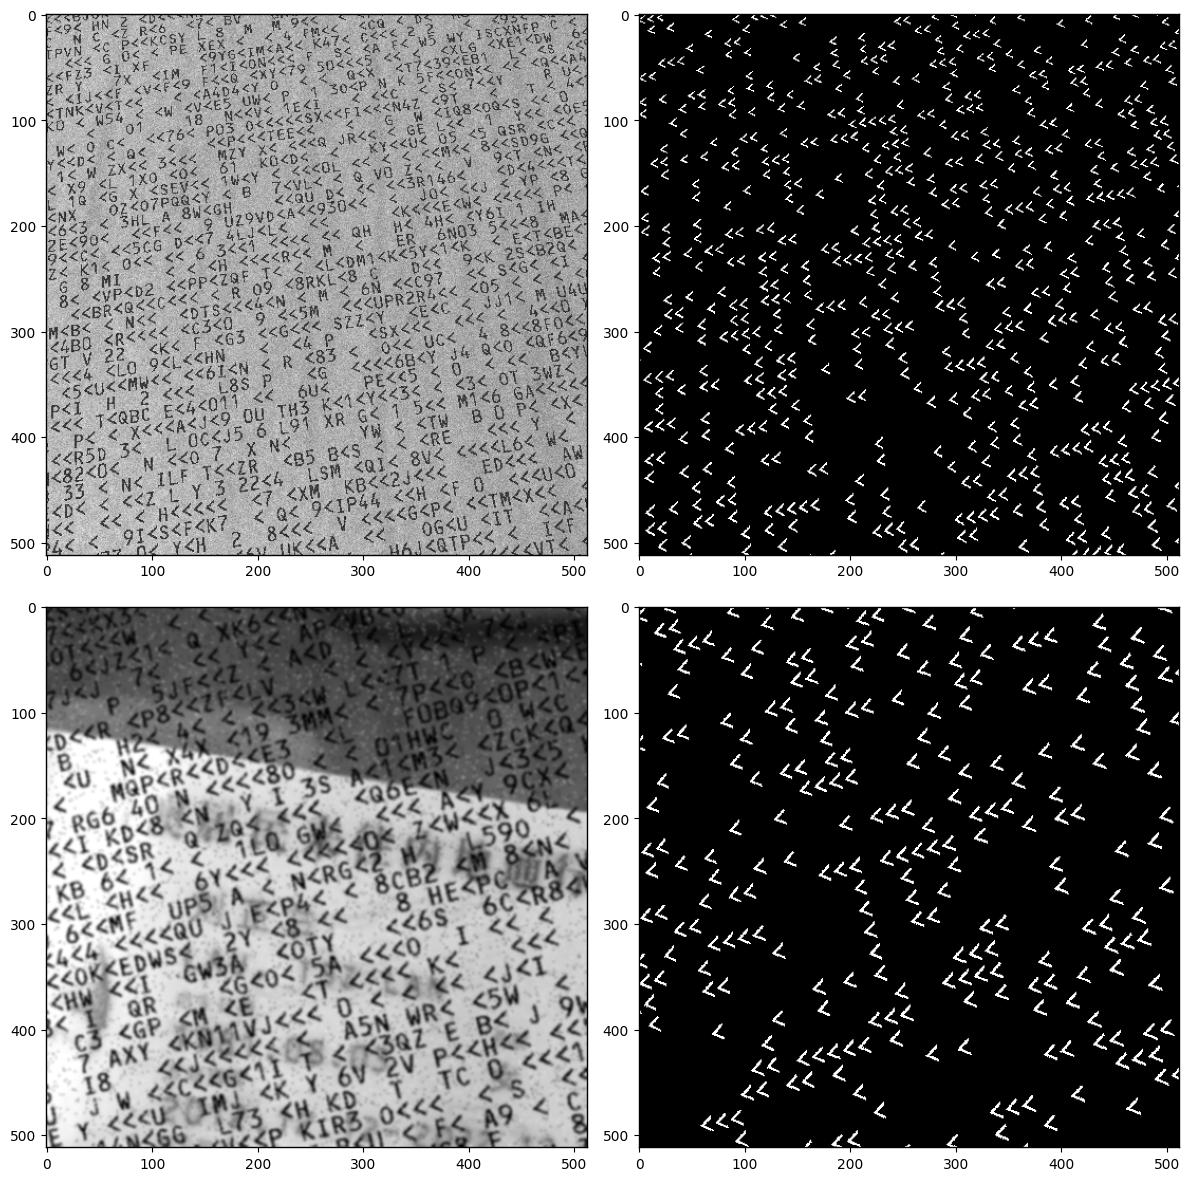

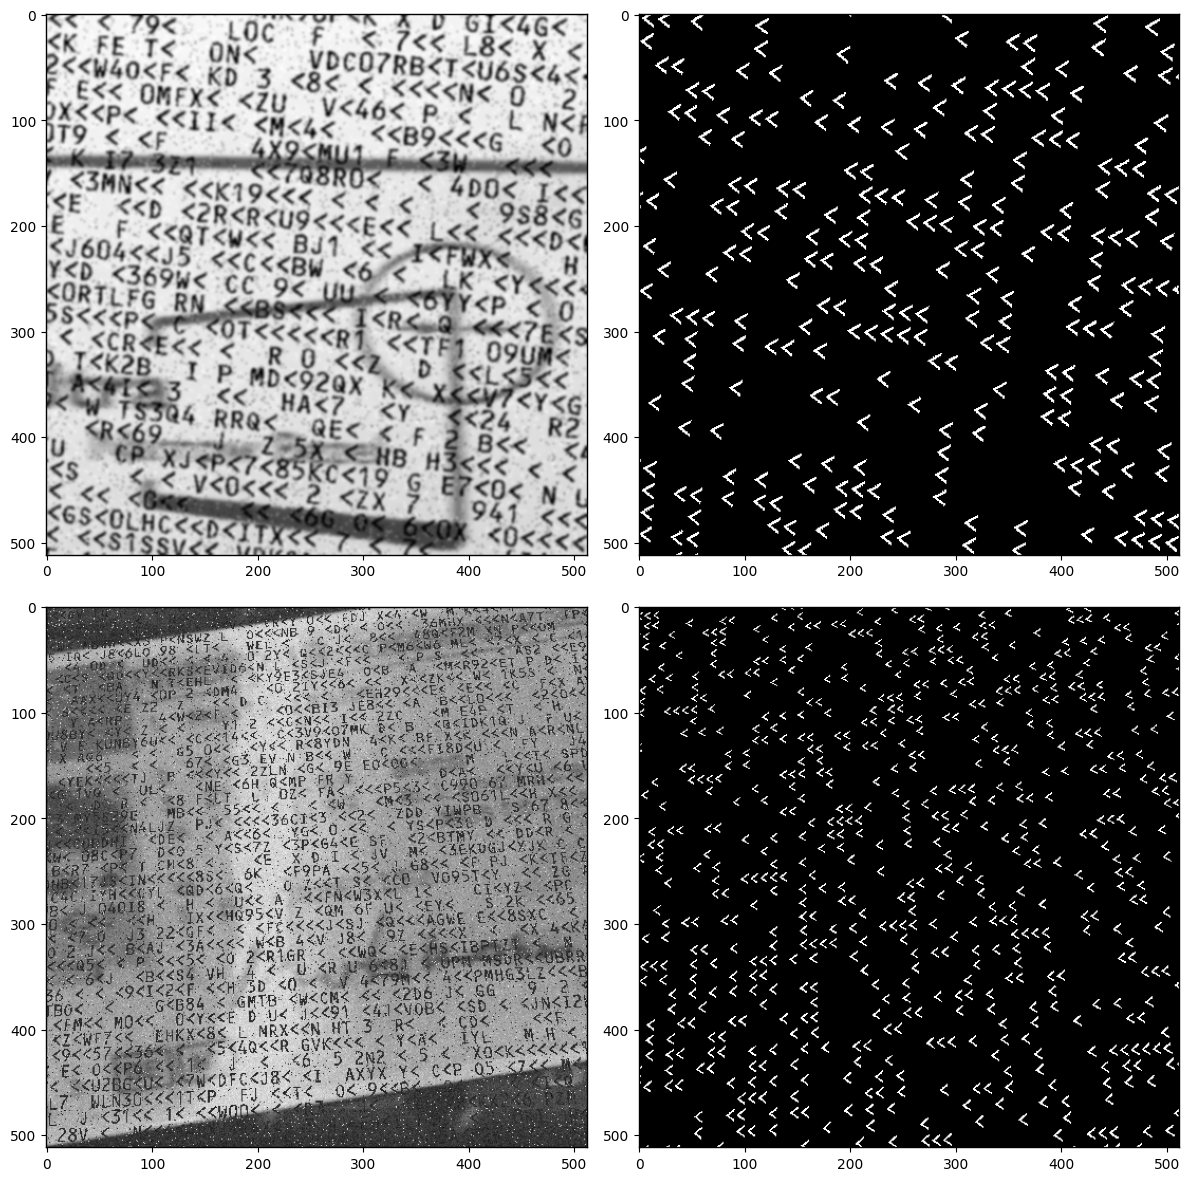

In [13]:
from src.training_data_generator import plot_samples

plot_samples(2)
plot_samples(2)

As validation data we use the sample image as well as images from the midv500 dataset. As he model learns on grayscale images I also show how these look.

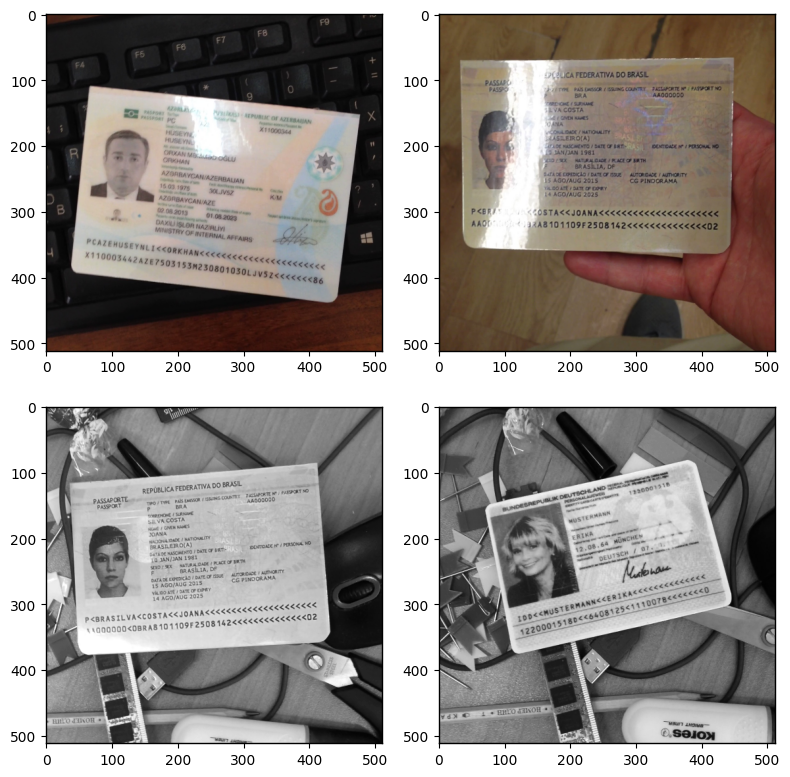

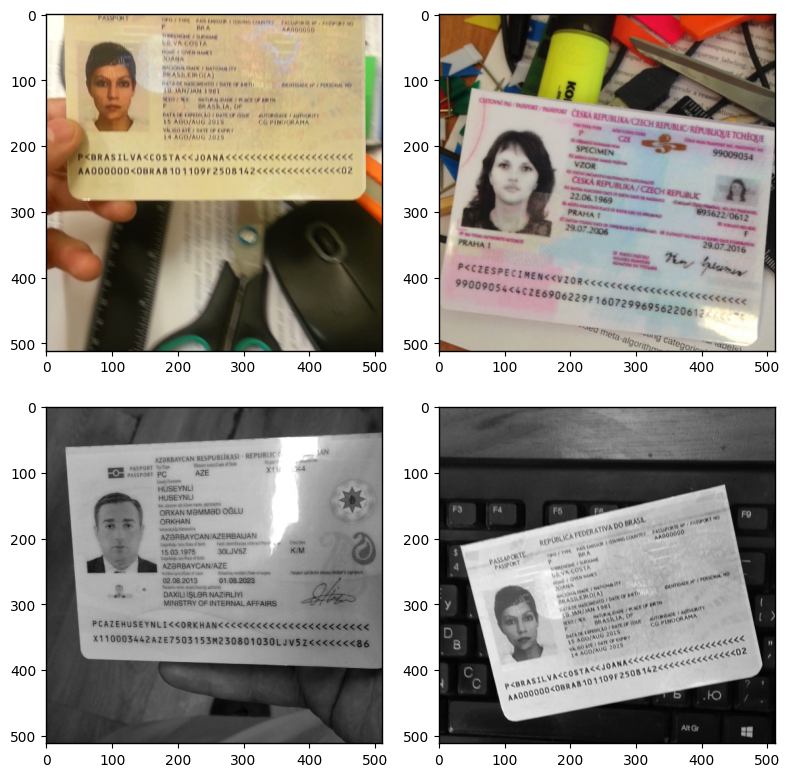

In [15]:
from src.image_loading import show_validation_crops
show_validation_crops(512, 512)
show_validation_crops(512, 512)

For segmenting the angle brackets I use a neural network that is inspired by the U-Net architecture. A fully convolutional neural network like this can be compared to a classic CV filter that we convolve an image with. As the angle brackets we look for a rather small, we dont need many max pooling layers to have reasonable kernel sizes for detecting angle brackets. Thus I use a shallow U-Net consisting of only two instead of the four encoder blocks in the original paper. I train the model on batches of 4 images for 200 epochs. In each epoch the model is trained on 15 batches. I optimzize the binary cross entropy loss using Adam as optimizing algorithm. We could test different learning algorithms, but as an adaptive learning rate optimizer with momentum Adam is a reasonable choice.
The metrics I track are accuracy and intersection over unity. IoU is a metric that makes more sense for a segmentation task, but as we see accuracy and IoU correlate.
In the next figures I plotted the metrics over the training period. Finally I ran the model on two training images as sanity check and on the initial sample image.

In [21]:
import pickle
from tensorflow import keras
import tensorflow as tf
from matplotlib import pyplot as plt
from src.model_unet import shallow_unet
from src.image_loading import sample_image, sample_image_generator
from src.training_data_generator import sample_generator_gray

keras.backend.clear_session()

# Build model
img_size = (512, 512) # shape of training images
num_classes = 2 # number of segmentation classes (angle bracket / other)
epochs = 200
steps_per_epoch = 15
model_name = "demonstration_model_200_epochs"
path_trained_model = f"data/trained_models/{model_name}.h5"
model = shallow_unet(1) # shallow u net with one color channel (grayscale)
model.summary()

train_dataset = tf.data.Dataset.from_generator(sample_generator_gray, output_signature=(
    tf.TensorSpec(shape=(*img_size, 1), dtype=tf.float32), tf.TensorSpec(shape=(*img_size, 2), dtype=tf.float32)))
train_dataset = train_dataset.batch(4)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(sample_image_generator, output_signature=(
    tf.TensorSpec(shape=(*img_size, 1), dtype=tf.float32), tf.TensorSpec(shape=(*img_size, 2), dtype=tf.float32)))
val_dataset = val_dataset.batch(4)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

model.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])])

# model = keras.models.load_model(path_trained_model)
model_history = model.fit(train_dataset, epochs=epochs, steps_per_epoch=steps_per_epoch,
                          validation_data=val_dataset)
model.save(path_trained_model)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   160         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   2320        ['conv2d[0][0]']                 
                                16)                                                           

Epoch 14/200
15/15 [==============================] - 49s 3s/step - loss: 0.0419 - accuracy: 0.3079 - io_u: 0.7213 - val_loss: 0.0743 - val_accuracy: 0.1154 - val_io_u: 0.5689
Epoch 15/200
15/15 [==============================] - 49s 3s/step - loss: 0.0493 - accuracy: 0.2700 - io_u: 0.6824 - val_loss: 0.0234 - val_accuracy: 0.2111 - val_io_u: 0.6375
Epoch 16/200
15/15 [==============================] - 49s 3s/step - loss: 0.0378 - accuracy: 0.3278 - io_u: 0.7372 - val_loss: 0.0197 - val_accuracy: 0.2239 - val_io_u: 0.6478
Epoch 17/200
15/15 [==============================] - 49s 3s/step - loss: 0.0404 - accuracy: 0.3133 - io_u: 0.7248 - val_loss: 0.0247 - val_accuracy: 0.1744 - val_io_u: 0.6092
Epoch 18/200
15/15 [==============================] - 49s 3s/step - loss: 0.0402 - accuracy: 0.3087 - io_u: 0.7184 - val_loss: 0.0309 - val_accuracy: 0.1884 - val_io_u: 0.6193
Epoch 19/200
15/15 [==============================] - 49s 3s/step - loss: 0.0402 - accuracy: 0.3194 - io_u: 0.7300 - val

15/15 [==============================] - 49s 3s/step - loss: 0.0190 - accuracy: 0.4093 - io_u: 0.8247 - val_loss: 0.0249 - val_accuracy: 0.3126 - val_io_u: 0.7294
Epoch 107/200
15/15 [==============================] - 48s 3s/step - loss: 0.0222 - accuracy: 0.4065 - io_u: 0.8231 - val_loss: 0.0275 - val_accuracy: 0.3124 - val_io_u: 0.7289
Epoch 108/200
15/15 [==============================] - 48s 3s/step - loss: 0.0132 - accuracy: 0.4488 - io_u: 0.8703 - val_loss: 0.0294 - val_accuracy: 0.3238 - val_io_u: 0.7418
Epoch 109/200
15/15 [==============================] - 48s 3s/step - loss: 0.0158 - accuracy: 0.4330 - io_u: 0.8565 - val_loss: 0.0300 - val_accuracy: 0.3268 - val_io_u: 0.7446
Epoch 110/200
15/15 [==============================] - 48s 3s/step - loss: 0.0201 - accuracy: 0.4018 - io_u: 0.8232 - val_loss: 0.0326 - val_accuracy: 0.3220 - val_io_u: 0.7395
Epoch 111/200
15/15 [==============================] - 48s 3s/step - loss: 0.0171 - accuracy: 0.4219 - io_u: 0.8407 - val_loss: 0

15/15 [==============================] - 48s 3s/step - loss: 0.0157 - accuracy: 0.4828 - io_u: 0.8752 - val_loss: 0.0175 - val_accuracy: 0.3405 - val_io_u: 0.7604
Epoch 199/200
15/15 [==============================] - 48s 3s/step - loss: 0.0126 - accuracy: 0.4679 - io_u: 0.8840 - val_loss: 0.0210 - val_accuracy: 0.2896 - val_io_u: 0.7059
Epoch 200/200
15/15 [==============================] - 48s 3s/step - loss: 0.0123 - accuracy: 0.4585 - io_u: 0.8810 - val_loss: 0.0289 - val_accuracy: 0.3230 - val_io_u: 0.7402


Overview of training progress.

dict_keys(['loss', 'accuracy', 'io_u', 'val_loss', 'val_accuracy', 'val_io_u'])


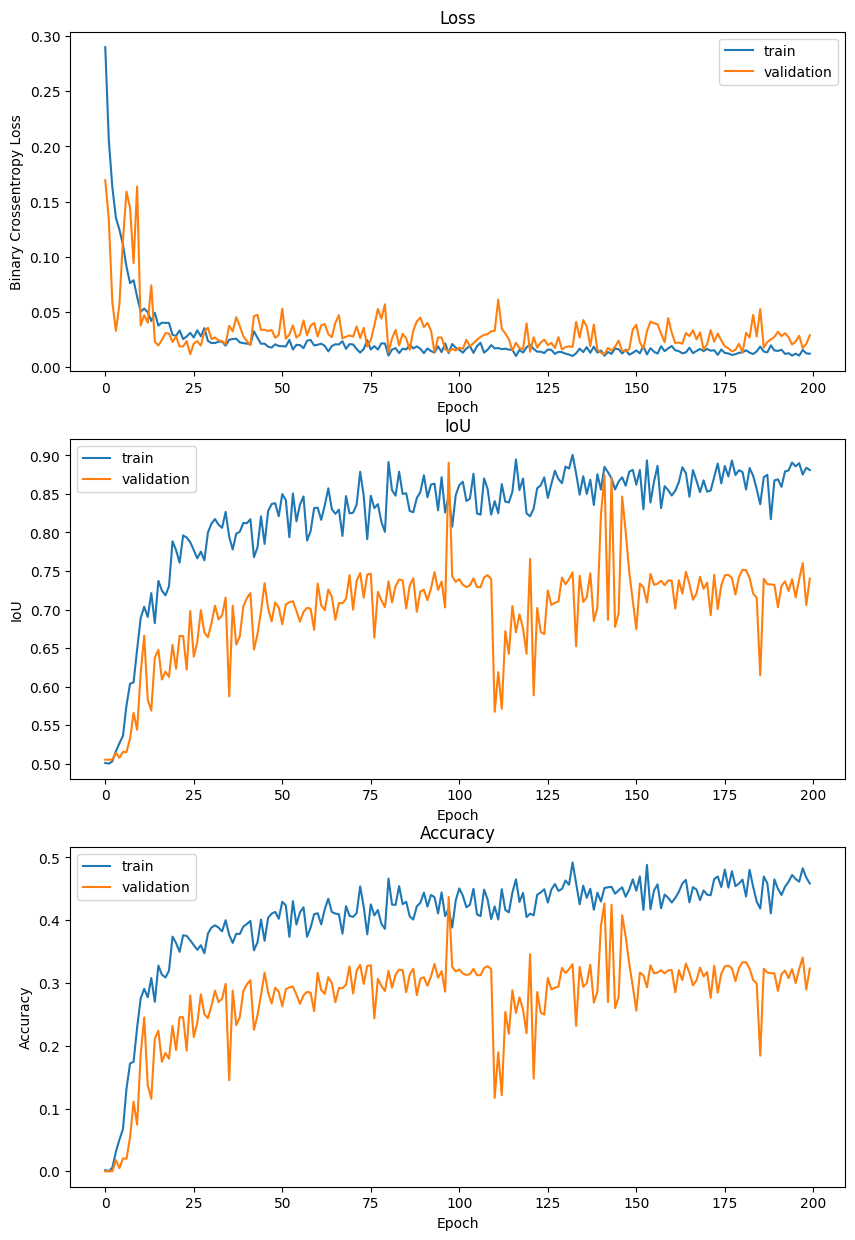

In [22]:

print(model_history.history.keys())
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
ax[0].set_title('Loss')
ax[0].plot(model_history.history['loss'], label='train')
ax[0].plot(model_history.history['val_loss'], label='validation')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Binary Crossentropy Loss')
ax[0].legend()

ax[1].set_title('IoU')
ax[1].plot(model_history.history['io_u'], label='train')
ax[1].plot(model_history.history['val_io_u'], label='validation')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('IoU')
ax[1].legend()

ax[2].set_title('Accuracy')
ax[2].plot(model_history.history['accuracy'], label='train')
ax[2].plot(model_history.history['val_accuracy'], label='validation')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Accuracy')
ax[2].legend()
plt.savefig(f"data/plots/{model_name}_loss.png")

Verify model training by running it on two training images and the sample image.

1/1 [==============================] - 0s 107ms/step


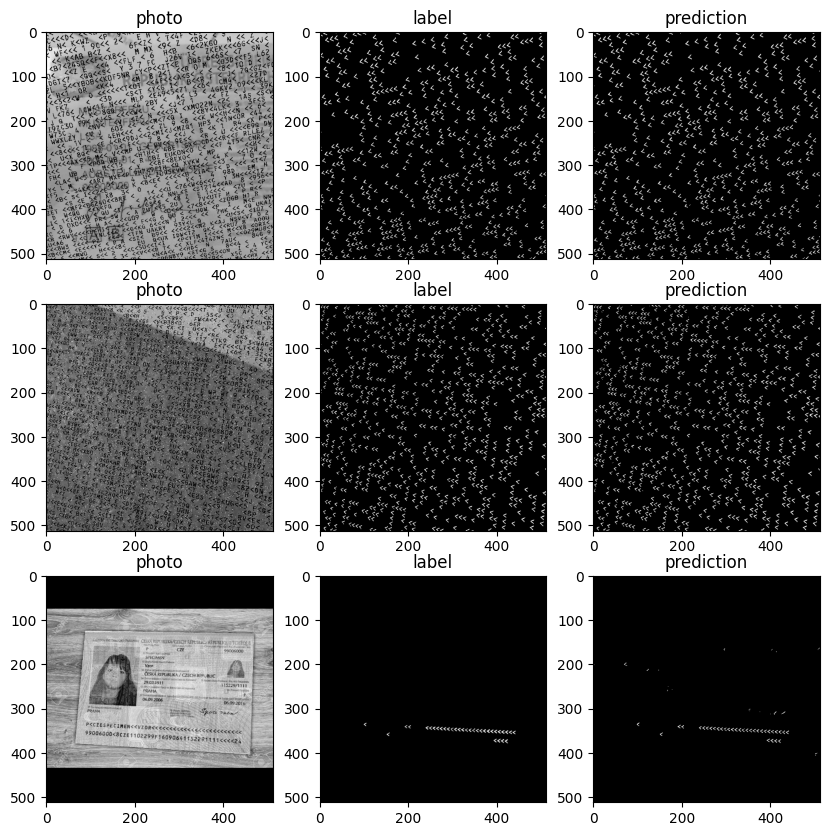

In [23]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for img, label in train_dataset.take(2):
    pred = model.predict(img)
    for ix in range(2):
        ax[ix][0].imshow(img[ix, :, :], cmap="gray")
        ax[ix][0].set_title('photo')
        ax[ix][1].imshow(label[ix, :, :, 0], cmap='gray')
        ax[ix][1].set_title('label')
        ax[ix][2].imshow(pred[ix, :, :, 0] >= pred[ix, :, :, 1], cmap='gray')
        # ax[ix][2].imshow(pred[ix, :, :, 0], cmap='gray')
        ax[ix][2].set_title('prediction')

for img, label in val_dataset.take(1):
    pred = model.predict(img)
    for ix in range(0, 1):
        ax[ix + 2][0].imshow(img[ix, :, :], cmap="gray")
        ax[ix + 2][0].set_title('photo')
        ax[ix + 2][1].imshow(label[ix, :, :, 0], cmap='gray')
        ax[ix + 2][1].set_title('label')
        ax[ix + 2][2].imshow(pred[ix, :, :, 0] >= pred[ix, :, :, 1], cmap='gray')
        # ax[ix + 2][2].imshow(pred[ix, :, :, 0], cmap='gray')
        ax[ix + 2][2].set_title('prediction')

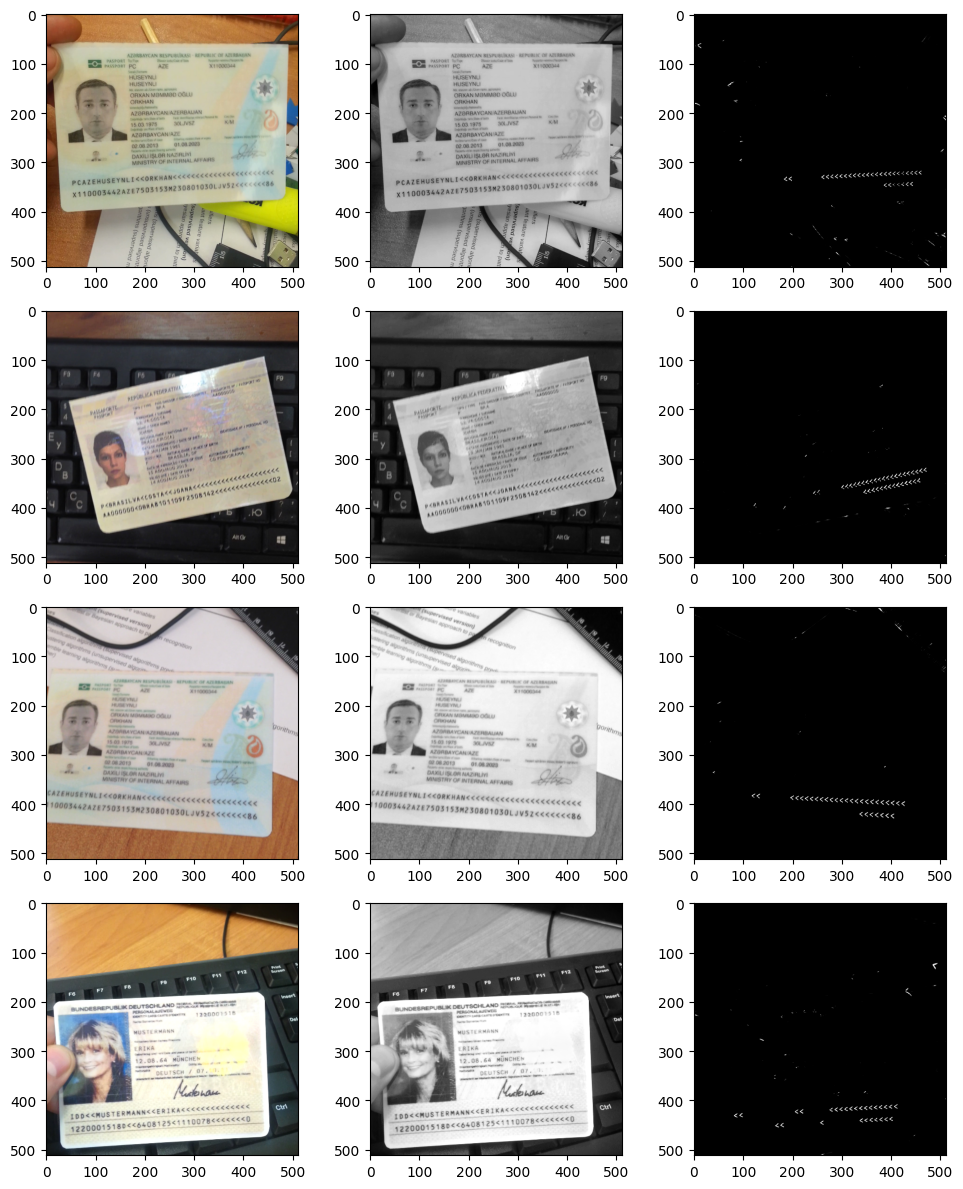

In [7]:
from matplotlib import pyplot as plt
from src.draw_bounding_box import generate_samples_and_predictions
samples, samples_gray, predictions = generate_samples_and_predictions(4, 512, 512, "demonstration_model_200_epochs")

fig, ax = plt.subplots(len(samples), 3, figsize=(10, 12))

for idx in range(len(samples)):
    ax[idx, 0].imshow(samples[idx])
    ax[idx, 1].imshow(samples_gray[idx], cmap="gray")
    ax[idx, 2].imshow(predictions[idx, :, :, 0], cmap="gray")
fig.tight_layout()

The U-Net performs quite well at segmenting the angle brackets eventhough there are some false positives.

Now I would like to locate the whole MRZ lines. As it turns out, classic cv methods are quite good at finding black text on white background. I use filters described in (https://pyimagesearch.com/2015/11/30/detecting-machine-readable-zones-in-passport-images/) to extract multiple text contours of an ID. But how do we find the contour around the two MRZ lines? For this we use the angle bracket segmentation mask my U-Net returns. We iterate over the 10 largest contours and let the white pixels of the segmentation mask vote for contours by checking if they are contained by it. We then output the bounding boxes of the two contours containing the most angle bracket pixels. Of course this only works if the U-Net outputs a reasonable segmentation mask. See the picutres here.

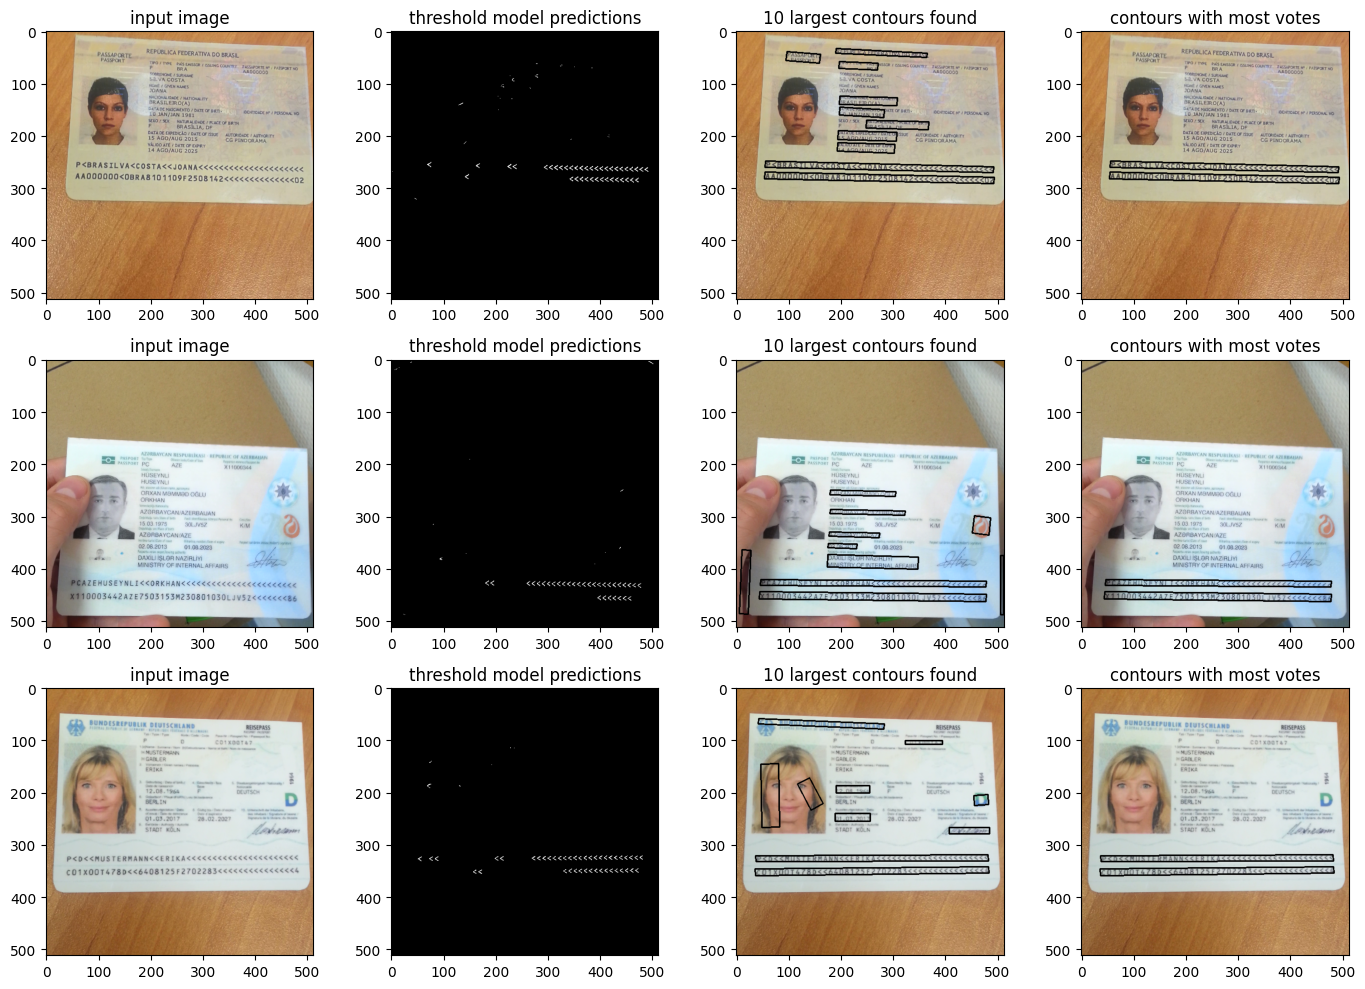

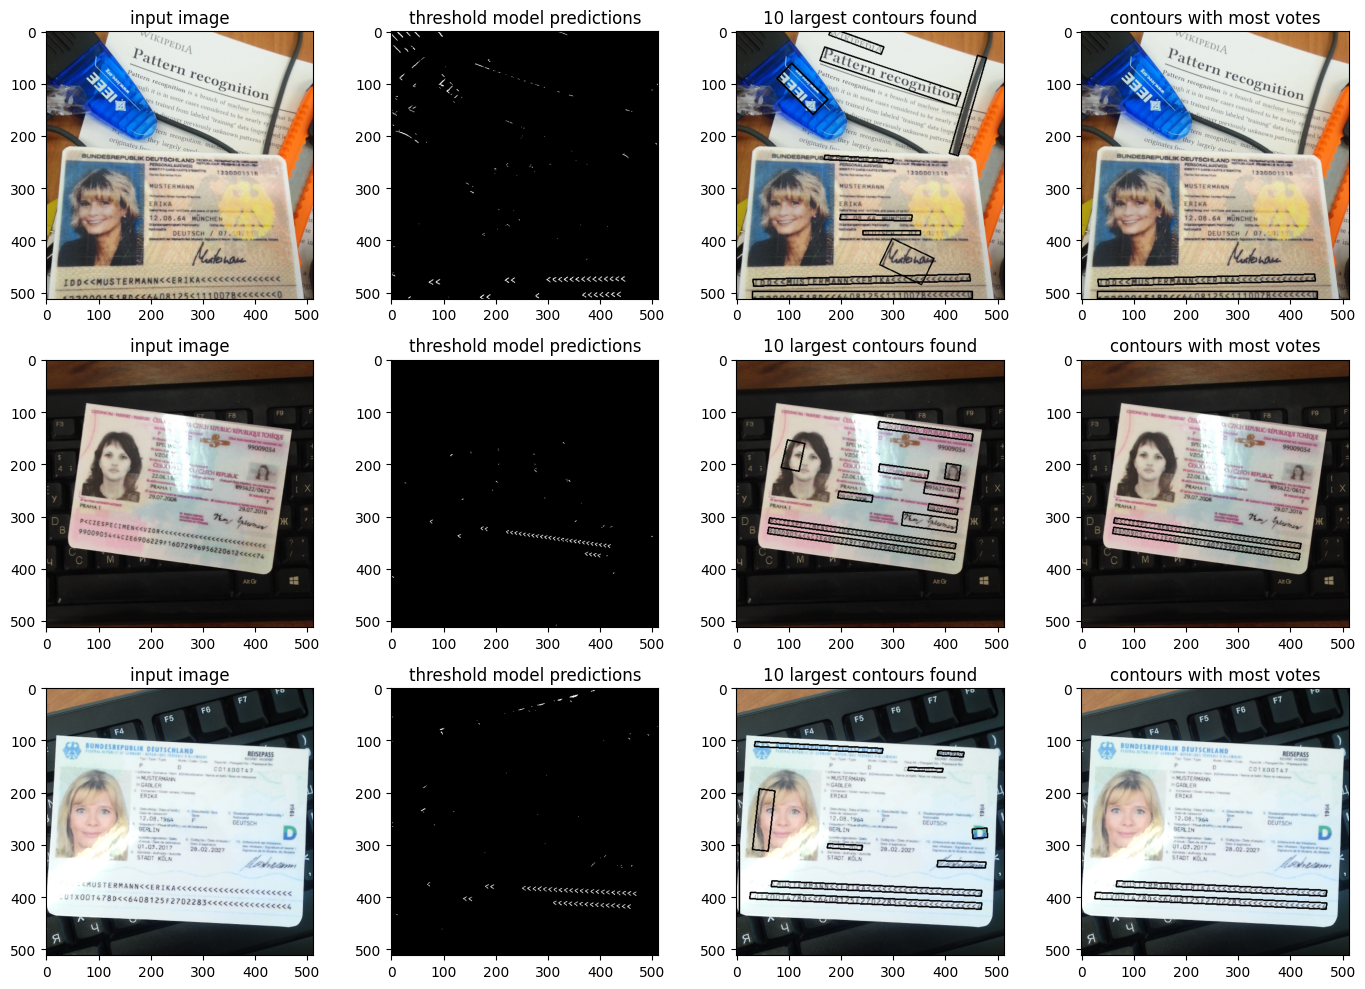

[None, None]

In [2]:
from src.draw_bounding_box import draw_mrz_lines_extraction_steps
[draw_mrz_lines_extraction_steps(3, "demonstration_model_200_epochs") for _ in range(2)]

We see that this method works quite well. However, we do rely on a good segmentation mask from our U-Net. The U-Net does however struggle a bit with blurred images. Some more training with blurred inputs might be needed.

Using filters on the whole image is rather costly. I would be smarter to first extract the MRZ region using the angle brackets and then apply the text detection filters only to that part of the image. To get the lines of text I explore algorithmic solutions in the "assign-bracket-to-line" notebook. Linear regression, RANSAC, DBSCAN and clustering algorithms can be used for this task.